In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


sample = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sample.head()

In [3]:
import zipfile

zip_files = ['test', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test unzipped
train unzipped


In [4]:
Train_Folder_Path = "../working/train"
Test_Folder_Path = "../working/test"
train_file_names = os.listdir(Train_Folder_Path)
test_file_names = os.listdir(Test_Folder_Path)
train_file_names[0:5]

['dog.3374.jpg',
 'cat.11875.jpg',
 'dog.4569.jpg',
 'dog.2083.jpg',
 'cat.5224.jpg']

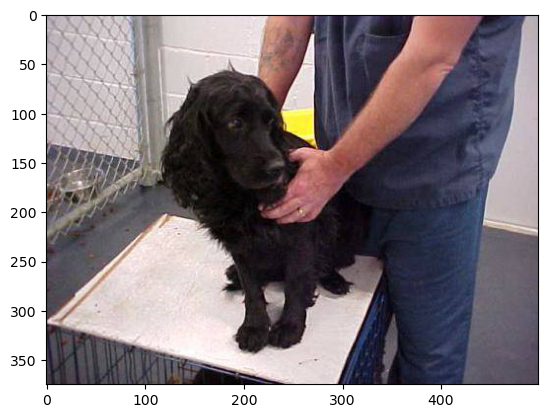

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("../working/train/dog.4135.jpg")
plt.imshow(img)
plt.show()

In [6]:
test_data = os.listdir(Test_Folder_Path)
test_data[:5]

['3769.jpg', '9204.jpg', '9979.jpg', '1016.jpg', '4281.jpg']

In [7]:
targets = []
full_paths = []
for file_name in train_file_names:
    target = file_name.split(".")[0]
    full_path = os.path.join(Train_Folder_Path, file_name)
    full_paths.append(full_path)
    targets.append(target)

train_df = pd.DataFrame()
train_df['image_path'] = full_paths
train_df['target'] = targets
train_df.head()

,image_path,target
0,../working/train/dog.3374.jpg,dog
1,../working/train/cat.11875.jpg,cat
2,../working/train/dog.4569.jpg,dog
3,../working/train/dog.2083.jpg,dog
4,../working/train/cat.5224.jpg,cat


In [8]:
full_paths = []
for file_name in test_file_names:
    target = file_name.split(".")[0]
    full_path = os.path.join(Test_Folder_Path, file_name)
    full_paths.append(full_path)

test_df = pd.DataFrame()
test_df['image_path'] = full_paths
test_df.head()

,image_path
0,../working/test/3769.jpg
1,../working/test/9204.jpg
2,../working/test/9979.jpg
3,../working/test/1016.jpg
4,../working/test/4281.jpg


In [9]:
from sklearn.model_selection import train_test_split
train_data,val_data = train_test_split(train_df,random_state=42)
print(len(train_data), len(val_data))

18750 6250


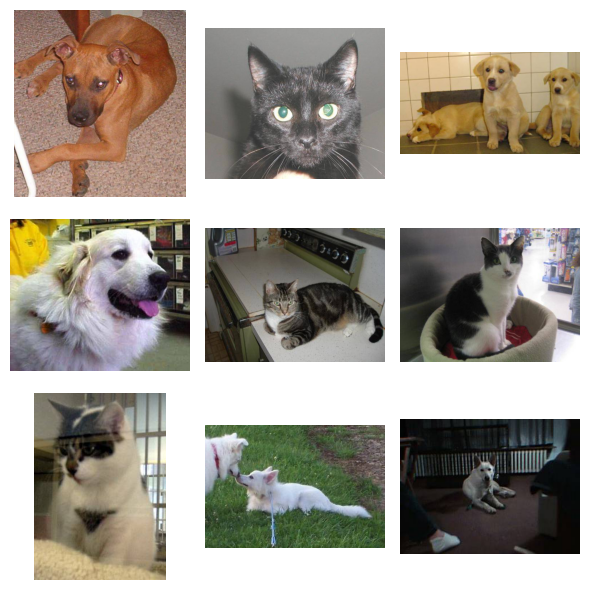

In [10]:
fig,axes=plt.subplots(3,3,figsize=(6,6))
axes = axes.ravel()
for i in range(9):
    axes[i].imshow(Image.open(train_df.iloc[i,0]))
    axes[i].axis('off')
fig.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=.18,
                                   rotation_range=10,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_data_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                         x_col='image_path',
                                                         y_col='target',
                                                         target_size=(150,150),
                                                         class_mode='binary',
                                                         batch_size=150,
                                                         shuffle=False)

Found 18750 validated image filenames belonging to 2 classes.


In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_data_generator = val_datagen.flow_from_dataframe(dataframe=val_data,
                                                     x_col='image_path',
                                                     y_col='target',
                                                     target_size=(150,150),
                                                     class_mode='binary',
                                                     batch_size=150,
                                                     shuffle=False)

Found 6250 validated image filenames belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                       x_col='image_path',
                                                       y_col=None,
                                                       target_size=(150,150),
                                                       class_mode=None,
                                                       batch_size=150,
                                                       shuffle=False)

Found 12500 validated image filenames.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(150,150,3),activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [2]:
from tensorflow.keras.utils import plot_model

In [3]:
plot_model(model,show_shapes=True,show_layer_names=True, dpi=300, to_file='12-7.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_data_generator,epochs=12,validation_data=val_data_generator,
                 validation_steps=val_data.shape[0]/150,
                 steps_per_epoch=train_data.shape[0]/150,
                 verbose=1)

Epoch 1/12


2023-04-18 06:25:46.079069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 185s 1s/step - loss: 0.9653 - accuracy: 0.5658 - val_loss: 0.6475 - val_accuracy: 0.6160
Epoch 2/12
125/125 [==============================] - 172s 1s/step - loss: 0.6486 - accuracy: 0.6326 - val_loss: 0.6386 - val_accuracy: 0.6395
Epoch 3/12
125/125 [==============================] - 171s 1s/step - loss: 0.6043 - accuracy: 0.6718 - val_loss: 0.5391 - val_accuracy: 0.7214
Epoch 4/12
125/125 [==============================] - 172s 1s/step - loss: 0.5776 - accuracy: 0.6965 - val_loss: 0.5515 - val_accuracy: 0.7160
Epoch 5/12
125/125 [==============================] - 172s 1s/step - loss: 0.5481 - accuracy: 0.7206 - val_loss: 0.5002 - val_accuracy: 0.7491
Epoch 6/12
125/125 [==============================] - 172s 1s/step - loss: 0.5264 - accuracy: 0.7371 - val_loss: 0.4764 - val_accuracy: 0.7666
Epoch 7/12
125/125 [==============================] - 172s 1s/step - loss: 0.5014 - accuracy: 0.7526 - val_loss: 0.4713 - val_accuracy: 0.7734
Epoch 8/12

In [17]:
score=model.evaluate(val_data_generator)

42/42 [==============================] - 20s 468ms/step - loss: 0.4252 - accuracy: 0.8038


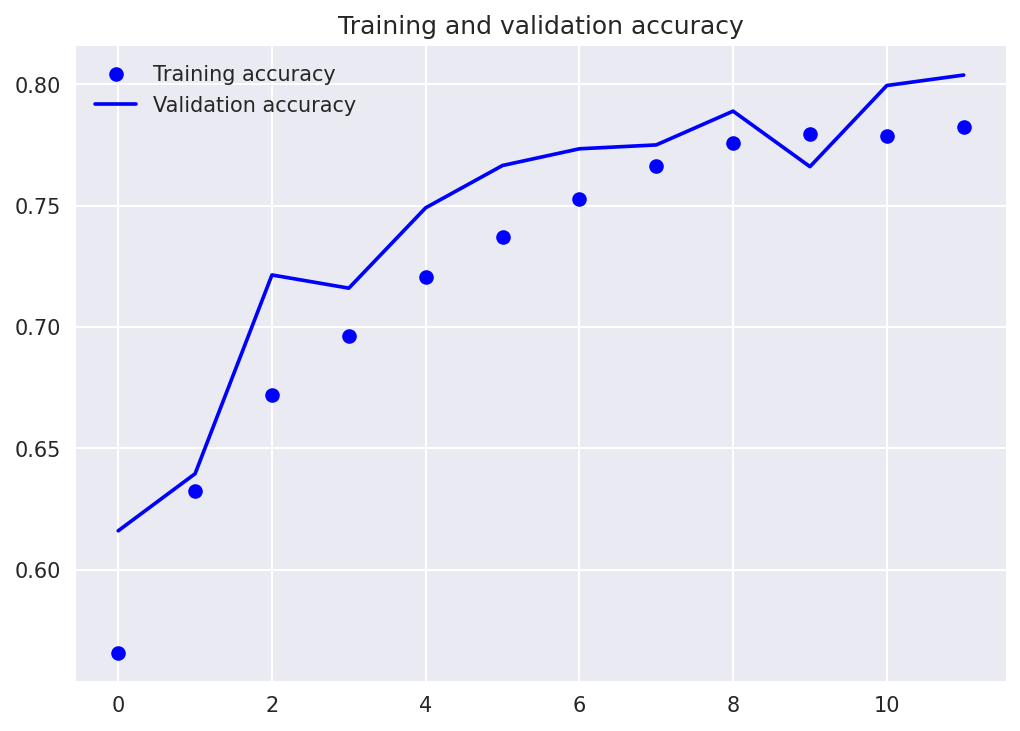

In [19]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))
plt.style.use('seaborn')
plt.figure(dpi=150)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

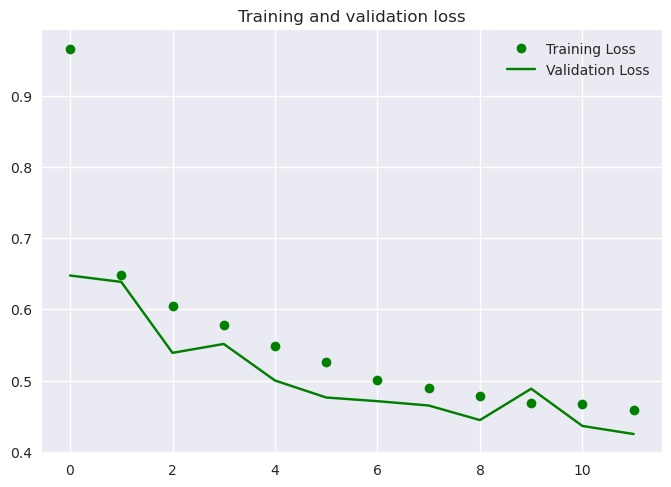

In [20]:
plt.figure()
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
predictions = model.predict(test_data_generator)

84/84 [==============================] - 41s 485ms/step


In [22]:
predictions = np.round(predictions.flatten()).astype(int)

In [23]:
test_label = []
a = os.listdir("../working/test")
for i in range(len(a)):
    test_label.append(a[i].split(".")[0])
submission = pd.DataFrame({'id':test_label,'label':predictions})
submission.to_csv("submission.csv",index=False)

In [24]:
df = pd.read_csv('/kaggle/working/submission.csv')
df.head()

,id,label
0,3769,1
1,9204,1
2,9979,0
3,1016,1
4,4281,0
